In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
from fastai.vision import *
from fastai.callbacks.hooks import *

In [5]:
path = Path(".")

In [6]:
path.ls()

[PosixPath('froth.ipynb'),
 PosixPath('images'),
 PosixPath('label_to_mask.py'),
 PosixPath('.ipynb_checkpoints'),
 PosixPath('labels'),
 PosixPath('codes.txt')]

In [7]:
path_lbl = path/"labels"
path_img = path/"images"

In [8]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('images/1575363424_5842041f4e65fad6a7708805.png'),
 PosixPath('images/1575363424_5842041f4e65fad6a7708832.png'),
 PosixPath('images/1575363424_5842041f4e65fad6a7708844.png')]

In [9]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('labels/1575363424_5842041f4e65fad6a7708805.png'),
 PosixPath('labels/1575363424_5842041f4e65fad6a7708832.png'),
 PosixPath('labels/1575363424_5842041f4e65fad6a7708844.png')]

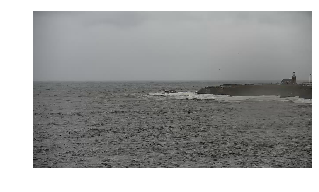

In [10]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [11]:
get_y_fn = lambda x: path_lbl/f"{x.stem}{x.suffix}"

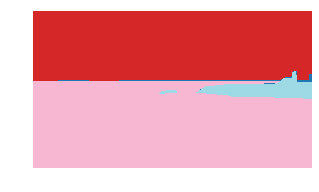

In [12]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [13]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([ 720, 1280]), tensor([[[1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          ...,
          [2, 2, 2,  ..., 2, 2, 2],
          [2, 2, 2,  ..., 2, 2, 2],
          [2, 2, 2,  ..., 2, 2, 2]]]))

In [14]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['__ignore__', '_background_', 'Sky', 'Ocean', 'Ground'], dtype='<U12')

In [15]:
size = src_size//2
bs=4

In [16]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_rand_pct()
       .label_from_func(get_y_fn, classes=codes))

In [17]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

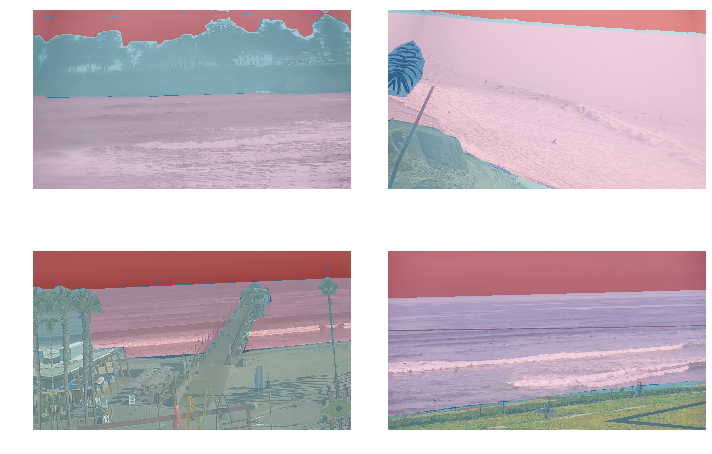

In [18]:
data.show_batch(2, figsize=(10,7))

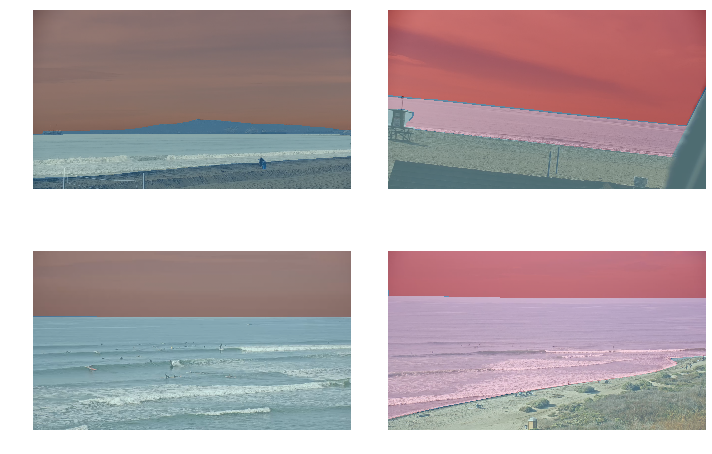

In [19]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

# Stage 1

In [20]:
name2id = {v:k for k,v in enumerate(codes)}
ignore_code = name2id['__ignore__']

def acc_labelme(input, target):
    target = target.squeeze(1)
    mask = target != ignore_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [21]:
metrics=acc_labelme

In [22]:
wd=1e-2

In [23]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


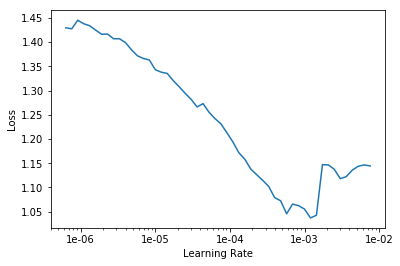

In [45]:
lr_find(learn)
learn.recorder.plot()

In [27]:
lr=3e-4

In [50]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_labelme,time
0,1.362678,1.221961,0.532863,00:14
1,1.172997,1.275846,0.554501,00:14
2,0.974969,1.150323,0.623224,00:14
3,0.870686,0.702151,0.696858,00:14
4,0.767228,0.584216,0.779117,00:14
5,0.673178,1.030496,0.673136,00:14
6,0.605216,0.471574,0.868007,00:14
7,0.580910,0.524364,0.811190,00:14
8,0.572256,0.679004,0.839075,00:14
9,0.550383,0.558681,0.838839,00:14


In [51]:
learn.save('stage-1')

In [24]:
learn.load('stage-1');

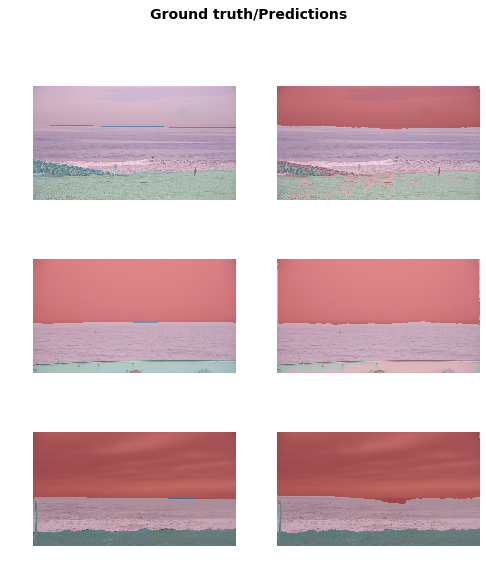

In [53]:
learn.show_results(rows=3, figsize=(8,9))

# Stage 2

In [25]:
learn.unfreeze()

In [28]:
lrs = slice(lr/400,lr/4)

In [29]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_labelme,time
0,0.405064,0.366102,0.956159,00:28
1,0.374336,0.369793,0.955256,00:13
2,0.367036,0.374264,0.951327,00:13
3,0.344138,0.346666,0.962859,00:13
4,0.327776,0.296761,0.974323,00:13
5,0.315943,0.247621,0.976833,00:12
6,0.299460,0.262851,0.977051,00:12
7,0.294991,0.388084,0.940603,00:13
8,0.291689,0.286979,0.977580,00:12
9,0.278546,0.280528,0.971485,00:12


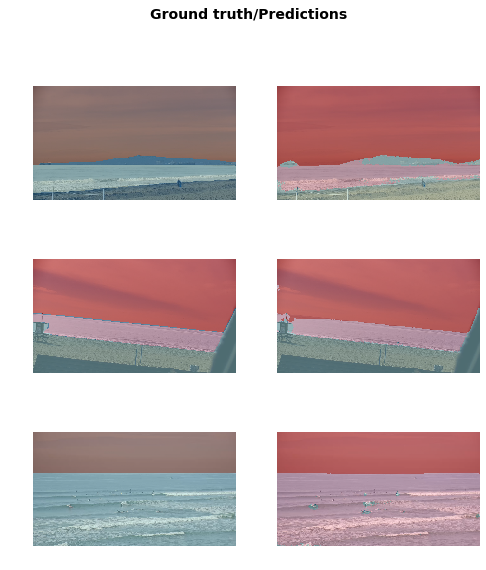

In [30]:
learn.show_results(rows=3, figsize=(8,9))

In [31]:
learn.save('stage-2')

# Stage 3 (Big)

In [32]:
learn.destroy()

this Learner object self-destroyed - it still exists, but no longer usable


In [33]:
size = src_size

In [35]:
bs=1

In [36]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [37]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [38]:
learn.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (33 items)
x: SegmentationItemList
Image (3, 720, 1280),Image (3, 720, 1280),Image (3, 720, 1280),Image (3, 720, 1280),Image (3, 720, 1280)
y: SegmentationLabelList
ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280)
Path: images;

Valid: LabelList (8 items)
x: SegmentationItemList
Image (3, 720, 1280),Image (3, 720, 1280),Image (3, 720, 1280),Image (3, 720, 1280),Image (3, 720, 1280)
y: SegmentationLabelList
ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280)
Path: images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPoo

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


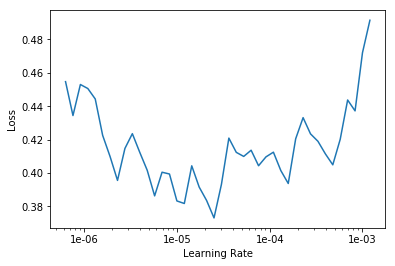

In [39]:
lr_find(learn)
learn.recorder.plot()

In [41]:
lr=2e-5

In [42]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_labelme,time
0,0.423640,0.365402,0.949528,00:46
1,0.396231,0.332273,0.958992,00:46
2,0.380074,0.339840,0.959951,00:46
3,0.385137,0.359361,0.957503,00:46
4,0.365647,0.380081,0.962508,00:46
5,0.344843,0.358113,0.967523,00:46
6,0.326258,0.352345,0.966060,00:46
7,0.319031,0.461617,0.939524,00:46
8,0.308715,0.336402,0.963970,00:46
9,0.290069,0.373732,0.963489,00:46


In [43]:
learn.save('stage-1-big')

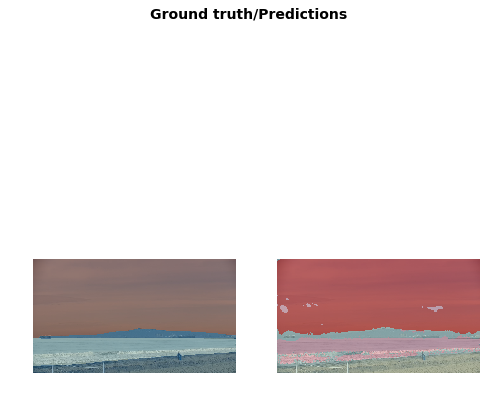

In [46]:
learn.show_results(rows=3, figsize=(8,9))